<a href="https://colab.research.google.com/github/LuisCGit/6.484-reinforcement-learning/blob/main/hyperparameter%20tuning%20(need%20better%20seeeds!).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Spring 2022 6.484 Computational Sensorimotor Learning Assignment 2

In this assignment, we will implement model-free RL algorithms from scratch to solve `DoorKeyEnv5x5`.  We will cover:


* REINFORCE
* Vanilla Policy Gradient (VPG)
* Generalized Advantage Estimation (GAE)
* Proximal Policy Optimization (PPO)

You will need to **answer the bolded questions** and **fill in the missing code snippets** (marked by **TODO**).

There are (approximately) **150** total points to be had in this PSET.  `ctrl-f` for "pts" to ensure you don't miss questions.

**_Please fill in your name below:_**

**Name**: Luis Costa Laveron

## Setup

The following code sets up requirements, imports, and helper functions (you can ignore this).

In [10]:
!pip install gym-minigrid &>/dev/null

In [11]:
import torch
import torch.nn as nn
from torch.distributions.categorical import Categorical
import torch.nn.functional as F
import gym_minigrid
import numpy as np
import matplotlib.pyplot as plt
import gym
from tqdm.notebook import tqdm
from gym_minigrid.envs.doorkey import DoorKeyEnv
from gym_minigrid.envs.empty import EmptyEnv
from gym_minigrid.envs.dynamicobstacles import DynamicObstaclesEnv5x5
import pandas as pd
import itertools
import random
import seaborn as sns
import math
import pickle
from gym_minigrid.envs.keycorridor import KeyCorridor
from gym_minigrid.envs.fourrooms import FourRoomsEnv
from gym_minigrid.envs.unlock import Unlock

In [12]:
from gym_minigrid.register import env_list
for env_idx, env_name in enumerate(env_list):
    print('testing {} ({}/{})'.format(env_name, env_idx+1, len(env_list)))

    # Load the gym environment
    env = gym.make(env_name)
    env.max_steps = min(env.max_steps, 200)
    env.reset()
    env.render('rgb_array')

    # # Verify that the same seed always produces the same environment
    # for i in range(0, 5):
    #     seed = 1337 + i
    #     env.seed(seed)
    #     grid1 = env.grid
    #     env.seed(seed)
    #     grid2 = env.grid
    #     assert grid1 == grid2

testing MiniGrid-Empty-5x5-v0 (1/71)
testing MiniGrid-Empty-Random-5x5-v0 (2/71)
testing MiniGrid-Empty-6x6-v0 (3/71)
testing MiniGrid-Empty-Random-6x6-v0 (4/71)
testing MiniGrid-Empty-8x8-v0 (5/71)
testing MiniGrid-Empty-16x16-v0 (6/71)
testing MiniGrid-DoorKey-5x5-v0 (7/71)
testing MiniGrid-DoorKey-6x6-v0 (8/71)
testing MiniGrid-DoorKey-8x8-v0 (9/71)
testing MiniGrid-DoorKey-16x16-v0 (10/71)
testing MiniGrid-MultiRoom-N2-S4-v0 (11/71)
testing MiniGrid-MultiRoom-N4-S5-v0 (12/71)
testing MiniGrid-MultiRoom-N6-v0 (13/71)
testing MiniGrid-Fetch-5x5-N2-v0 (14/71)
testing MiniGrid-Fetch-6x6-N2-v0 (15/71)
testing MiniGrid-Fetch-8x8-N3-v0 (16/71)
testing MiniGrid-GoToObject-6x6-N2-v0 (17/71)
testing MiniGrid-GoToObject-8x8-N2-v0 (18/71)
testing MiniGrid-GoToDoor-5x5-v0 (19/71)
testing MiniGrid-GoToDoor-6x6-v0 (20/71)
testing MiniGrid-GoToDoor-8x8-v0 (21/71)
testing MiniGrid-PutNear-6x6-N2-v0 (22/71)
testing MiniGrid-PutNear-8x8-N3-v0 (23/71)
testing MiniGrid-LockedRoom-v0 (24/71)
testing Min

In [13]:
from gym_minigrid.wrappers import *
# env = gym.make('MiniGrid-Empty-8x8-v0')
# env = ImgObsWrapper(env) 
# env

In [14]:
# Function from https://github.com/ikostrikov/pytorch-a2c-ppo-acktr/blob/master/model.py
def init_params(m):
    classname = m.__class__.__name__
    if classname.find("Linear") != -1:
        m.weight.data.normal_(0, 1)
        m.weight.data *= 1 / torch.sqrt(m.weight.data.pow(2).sum(1, keepdim=True))
        if m.bias is not None:
            m.bias.data.fill_(0)

def preprocess_obss(obss, device=None):
    if isinstance(obss, dict):
        images = np.array([obss["image"]])
    else:
        images = np.array([o["image"] for o in obss])
    
    return torch.tensor(images, device=device, dtype=torch.float)

# class DoorKeyEnv5x5(DoorKeyEnv):
#     def __init__(self):
#         super().__init__(size=5)
    
#     def _reward(self):
#         """
#         Compute the reward to be given upon success
#         """
#         return 1
class DoorKeyEnvSparse(DoorKeyEnv):
    def __init__(self, size):
        super().__init__(size=size)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1
class EmptyEnvSparse(EmptyEnv):
    def __init__(self, size):
        super().__init__(size=size)
    
    def _reward(self):
        """
        Compute the reward to be given upon success
        """
        return 1

In [15]:
class Config:
    def __init__(self,
                score_threshold=0.93,
                discount=0.995,
                lr=1e-3,
                max_grad_norm=0.5,
                log_interval=10,
                max_episodes=2000,
                gae_lambda=0.95,
                use_critic=False,
                clip_ratio=0.2,
                target_kl=0.01,
                train_ac_iters=5,
                use_discounted_reward=False,
                entropy_coef=0.01,
                explore_c = 1,
                use_gae=False):
        
        self.score_threshold = score_threshold
        self.discount = discount
        self.lr = lr
        self.max_grad_norm = max_grad_norm
        self.log_interval = log_interval
        self.max_episodes = max_episodes
        self.use_critic = use_critic
        self.clip_ratio = clip_ratio
        self.target_kl = target_kl
        self.train_ac_iters = train_ac_iters
        self.gae_lambda=gae_lambda
        self.use_discounted_reward=use_discounted_reward
        self.entropy_coef = entropy_coef
        self.explore_c = explore_c
        self.use_gae = use_gae

# Task (Environment)

In this assignment, we will work with the `DoorKeyEnv5x5` environment from [gym_miniworld](https://github.com/maximecb/gym-minigrid). This environment is a $5\times 5$ gridworld. The agent needs to pick up the key, open the door, and then go the the green cell. The agent gets a $+1$ reward if it reaches the green cell, and a $0$ reward otherwise.

The environment is visually shown below:

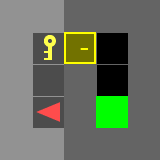

In [16]:

# env = DoorKeyEnv5x5()
env_name = 'MiniGrid-DoorKey-6x6-v0'
env = gym.make(env_name)


**Question**: What does `env.reset()` return? What does each item returned mean? What's the shape of the image in the observation? How about the action space? What does each action mean? (Hint: You may find the source code of gym_minigrid helpful.) (10 pts)

**A**: `env.reset()` returns an observation variable, which is a dictionary that contains the current view of the environment (as an image)., agent's facing direction (0: right, 1: down, 2: left, 3: up), a mission description as a string. The current view of the environment has a similar format as a normal 3-channel image (shape: $7\times7\times3$), but it is not an actual image. The values are not pixels. Each value represents a state of the object on that location. Checkout [the source code](https://github.com/maximecb/gym-minigrid/blob/master/gym_minigrid/minigrid.py) for more details. The action space is $7$-dimensional: 0: turn left, 1: turn right, 2: forward, 3: pickup an object, 4: drop an object, 5: activate an object, 6: done completing task.

# Model

In Deep Q-Learning, we estimated the value function for each (state, action) pair. In policy gradients, we will directly learn a policy: i.e, for each state, predict an action!  We call this policy network the *actor*.

Our *actor* will take in as input the `DoorKeyEnv5x5` observation (a 7x7x3 image), and output a categorical distribution over all possible actions.  To choose an action, we will sample from this distribution.  We suggest implementing the actor network to contain a few convolutional layers, followed by a few fully-connected layers.

In addition to the actor network, later questions in the PSET require estimating the value network, called the *critic*.  The critic estimates total future reward, much like DQN in PSET 3, but is notably *on-policy*, meaning it's reward estimates are conditioned on the actor. We will use the critic to reduce variance in the policy gradient estimate. We will get to that soon. 

We have provided you a reference architecture to use for your actor-critic networks. Note that we have separate networks for each that do not share weights, as this has been shown to empirically improve performance. Also note that the policy outputs a `torch.distributions.categorical.Categorical` object.


In [17]:
#https://discuss.pytorch.org/t/how-can-i-connect-a-new-neural-network-after-a-trained-neural-network-and-optimize-them-together/48293/4
class Critic(nn.Module):
  def __init__(self):
    super().__init__()
    self.conv = nn.Sequential(
                        nn.Conv2d(3, 16, (2, 2)),
                        nn.ReLU(),
                        nn.MaxPool2d((2, 2)),
                        nn.Conv2d(16, 32, (2, 2)),
                        nn.ReLU(),
                        nn.Conv2d(32, 64, (2, 2)),
                        nn.ReLU()
                      )
    self.lin = nn.Sequential(
                        nn.Linear(64, 64),
                        nn.Tanh(),
                        nn.Linear(64, 1)
                      )
  def forward(self, obs):
    conv_in = obs.transpose(1, 3).transpose(2, 3)
    y = self.conv(conv_in)
    embedding = y.reshape(y.shape[0], -1)
    v = self.lin(embedding).squeeze(1)
    return v



class ACModel(nn.Module):
    def __init__(self, num_actions, use_critic=False,num_critics=1):
        super().__init__()
        self.use_critic = use_critic
        self.num_critics = num_critics

        ##### TODO: initialize actor and critic networks #######
        
        # Define actor's model
        self.image_conv_actor = nn.Sequential(
            nn.Conv2d(3, 16, (2, 2)),
            nn.ReLU(),
            nn.MaxPool2d((2, 2)),
            nn.Conv2d(16, 32, (2, 2)),
            nn.ReLU(),
            nn.Conv2d(32, 64, (2, 2)),
            nn.ReLU()
        )
        self.actor = nn.Sequential(
            nn.Linear(64, 64),
            nn.Tanh(),
            nn.Linear(64, num_actions)
        )

        # Define critic's model
        if self.use_critic:
            critics = nn.ModuleList()
            for i in range(num_critics):
              critics.append(Critic())
            self.critics = critics
        ########################################################

        # Initialize parameters correctly (don't remove this!)
        self.apply(init_params)

    def forward(self, obs):
        conv_in = obs.transpose(1, 3).transpose(2, 3) # reshape into expected order

        dist, value = None, None
        ##### TODO: produce Categorical action distribtuion and critic value output #####
        ##### if self.use_critic is false, return all zeros for value ###################
        x = self.image_conv_actor(conv_in)
        embedding = x.reshape(x.shape[0], -1)

        x = self.actor(embedding)
        dist = Categorical(logits=F.log_softmax(x, dim=1))

        if self.use_critic:
            # y = self.image_conv_critic(conv_in)
            # embedding = y.reshape(y.shape[0], -1)

            # value = self.critic(embedding).squeeze(1)
            value = torch.zeros((x.shape[0], self.num_critics), device=x.device)
            for i, critic in enumerate(self.critics):
              value[:,i] = critic(obs)
        else:
            value = torch.zeros((x.shape[0], 1), device=x.device)
        ##################################################################################

        return dist, value

# Model Evaluation

The following code runs the actor critic model `acmodel` for one episode, and returns a dictionary with all the relevant information from the rollout.  It relies on placeholders below for `compute_advantage_gae` and `compute_discounted_return`: you can ignore these for now, and just evaluate through to the next section.  However, it might be useful to review this code just to make sure you understand what's going on.

In [18]:
def compute_advantage_gae(values, rewards, T, gae_lambda, discount, args, uncertainty_aware = True):
    vars = values.var(dim=1)
    values = values.mean(dim=1)
    advantages = torch.zeros_like(values)

    #### TODO: populate GAE in advantages over T timesteps (10 pts) ############
    for i in reversed(range(T)):
        next_value = values[i+1]
        next_advantage = advantages[i+1]

        delta = rewards[i] + args.discount * next_value  - values[i]
        advantages[i] = delta + args.discount * args.gae_lambda * next_advantage 
    ############################################################################
    #print("OLD ADV: ", advantages)
    if uncertainty_aware:
      if args.reward == "exponential":
        advantages = advantages * torch.exp(-1 * vars)
      elif args.reward == "explore":
        advantages = advantages + args.explore_c * vars
      elif args.reward == "threshold":
        advantages[:args.t] =  advantages[:args.t] + vars[:args.t]
        advantages[args.t:] =  advantages[args.t:] * torch.exp(-1 * vars[args.t:])
    #print("NEW ADV: ", advantages)
    return advantages[:T]

In [19]:
def compute_discounted_return(rewards, discount, device=None):
    returns = torch.zeros(*rewards.shape, device=device)

    #### TODO: populate discounted reward trajectory (10 pts) ############
    R = 0
    for t in reversed(range((rewards.shape[0]))):
        R = rewards[t] + discount * R
        returns[t] = R
    ######################################################################

    return returns

In [20]:
def collect_experiences(env, acmodel, args, pbar, device=None):
    """Collects rollouts and computes advantages.
    Returns
    -------
    exps : dict
        Contains actions, rewards, advantages etc as attributes.
        Each attribute, e.g. `exps['reward']` has a shape
        (self.num_frames, ...).
    logs : dict
        Useful stats about the training process, including the average
        reward, policy loss, value loss, etc.
    """


    # MAX_FRAMES_PER_EP = 300
    if args.env_name in ['MiniGrid-Empty-8x8-v0', 'MiniGrid-DoorKey-6x6-v0','MiniGrid-DoorKey-16x16-v0']:
      MAX_FRAMES_PER_EP = 600
    else:
      MAX_FRAMES_PER_EP = 300
    shape = (MAX_FRAMES_PER_EP, )

    actions = torch.zeros(*shape, device=device, dtype=torch.int)
    values = torch.zeros((MAX_FRAMES_PER_EP, acmodel.num_critics), device=device)
    rewards = torch.zeros(*shape, device=device)
    log_probs = torch.zeros(*shape, device=device)
    obss = [None]*MAX_FRAMES_PER_EP

    obs = env.reset()

    total_return = 0

    T = 0

    while True:
        # Do one agent-environment interaction

        preprocessed_obs = preprocess_obss(obs, device=device)
        
        with torch.no_grad():
            dist, value = acmodel(preprocessed_obs)
        action = dist.sample()[0]

        obss[T] = obs
        obs, reward, done, _ = env.step(action.item())


        # Update experiences values
        actions[T] = action
        values[T] = value
        rewards[T] = reward
        log_probs[T] = dist.log_prob(action)


        total_return += reward
        T += 1

        if done:
            break

    discounted_reward = compute_discounted_return(rewards[:T], args.discount, device)
    if acmodel.num_critics == 1:
      advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount, args, uncertainty_aware = False)
    else:
      advantage_gae=compute_advantage_gae(values, rewards, T, args.gae_lambda, args.discount, args, uncertainty_aware = True)
    exps = dict(
        obs = preprocess_obss([
            obss[i]
            for i in range(T)
        ], device=device),
        action = actions[:T],
        value  = values[:T],
        reward = rewards[:T],
        advantage = discounted_reward-values[:T,:].mean(dim=1),
        log_prob = log_probs[:T],
        discounted_reward = discounted_reward,
        advantage_gae=advantage_gae
    )

    logs = {
        "return_per_episode": total_return,
        "num_frames": T
    }

    return exps, logs

In [21]:
def run_experiment(args, parameter_update):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    if args.env_name in ['MiniGrid-Empty-8x8-v0', 'MiniGrid-DoorKey-6x6-v0','MiniGrid-DoorKey-16x16-v0']:
      args.max_episodes = 10**4
    env = args.env

    acmodel = ACModel(env.action_space.n, use_critic=args.use_critic, num_critics = args.num_critics)
    acmodel.to(device)

    is_solved = False
    
    SMOOTH_REWARD_WINDOW = 50

    pd_logs, rewards = [], [0]*SMOOTH_REWARD_WINDOW
    actor_params = acmodel.parameters()
    optimizer_actor = torch.optim.Adam(actor_params, lr=args.lr)
    num_frames = 0

    pbar = tqdm(range(args.max_episodes))
    for update in pbar:
        exp, logs = collect_experiences(env, acmodel, args, update, device)
        logs_actor = parameter_update(optimizer_actor, acmodel, exp, args, target_params = "actor")
        #log data
        rewards.append(logs["return_per_episode"])
        num_frames += logs["num_frames"]
        smooth_reward = np.mean(rewards[-SMOOTH_REWARD_WINDOW:])
        data = {'episode':update, 'num_frames':num_frames, 'smooth_reward':smooth_reward,
                'reward':logs["return_per_episode"], 'policy_loss':logs_actor["policy_loss"]}
          
        if args.use_critic:
          data['value_loss'] = logs_actor["value_loss"]
        pd_logs.append(data)
        pbar.set_postfix(data)
        # Early terminate
        if smooth_reward >= args.score_threshold:
            is_solved = True
            break
        if is_solved: break
        for b in range(acmodel.num_critics):
          if (np.random.random() <= 0.67) or (acmodel.num_critics == 1):
            critic_params = acmodel.critics[b].parameters()
            optimizer_critic = torch.optim.Adam(critic_params, lr=args.lr)
            logs_critic = parameter_update(optimizer_critic, acmodel, exp, args, target_params = "critic",critic_index = b)

    if is_solved:
        print('Solved!')
    
    return pd.DataFrame(pd_logs).set_index('episode')


# REINFORCE

Now comes the fun part!  Using the `collect_experiences` function and `ACModel`, we will implement vanilla policy gradients.  The following function takes in an `optimizer`, `ACModel`, batch of experience `sb`, and some arguments `args` (see `Config` in setup for fields and default values), and should perform a policy gradients parameter update using the observed experience.

Fill in todos below to implement vanilla policy gradients (20 pts).

In [22]:
def update_parameters_reinforce(optimizer, acmodel, sb, args):
    def _compute_policy_loss(logps, returns):
        policy_loss = torch.tensor(0)

        #### TODO: complete policy loss (10 pts) ###
        policy_loss = -(logps * returns).mean()
        ############################################

        return policy_loss


    logps, reward = None, None
    
    ### TODO: compute logps and reward from acmodel, sb['obs'], sb['action'], and sb['reward'] ###
    ### If args.use_discounted_reward is True, use sb['discounted_reward'] instead. ##############
    ### (10 pts) #########################################
    dist, _= acmodel(sb['obs'])           
    logps = dist.log_prob(sb['action']) 

    # NOTE: simply setting rewards = sb['reward'] is also sufficient for full credit due to 
    # some abiguities on our part
    if args.use_discounted_reward:
        reward = sb['discounted_reward']
    else:
        rewards = sb['reward']
        rewards_len = rewards.size()[0]
        returns = np.zeros((rewards_len)).astype(np.float32)
        R = 0
        for t in reversed(range((rewards_len))):
            R = rewards[t] + R
            returns[t] = R
        reward = torch.from_numpy(returns).to(sb['reward'].device)
    ##############################################################################################

    policy_loss = _compute_policy_loss(logps, reward)
    update_policy_loss = policy_loss.item()

    # Update actor-critic
    optimizer.zero_grad()
    policy_loss.backward()
    
    # Perform gradient clipping for stability
    for p in acmodel.parameters():
        if p.grad is None:
            print("Make sure you're not instantiating any critic variables when the critic is not used")
    update_grad_norm = sum(p.grad.data.norm(2) ** 2 for p in acmodel.parameters()) ** 0.5
    torch.nn.utils.clip_grad_norm_(acmodel.parameters(), args.max_grad_norm)
    optimizer.step()

    # Log some values
    logs = {
        "policy_loss": update_policy_loss,
        "grad_norm": update_grad_norm
    }

    return logs

Now, let's try to run our implementation.  The following experiment harness is written for you, and will run sequential episodes of policy gradients until `args.max_episodes` timesteps are exceeded or the rolling average reward (over the last 100 episodes is greater than `args.score_threshold`. It is expected to get highly variable results, and we'll visualize some of this variability at the end.

The method accepts as arguments a `Config` object `args`, and a `parameter_update` method (such as `update_parameters_reinforce`).

# Proximal Policy Optimization

Our work is not yet done!  There are some surprisingly powerful additional tweaks we can make to our GAE implementation to further improve performance.

The current standard in policy gradients today is [Proximal Policy Optimization](https://arxiv.org/abs/1707.06347), which improves on GAE by taking multiply policy update steps per minibatch, enabled by policy update clipping (this is a specific variant called *PPO-Clip*).  This leads to greater sample efficiency, as larger steps can be taken from the same data samples.

We've implemented most of PPO for you: all that's left for you are the policy and value loss computations (note that you'll have to evaluate the `acmodel` each time you compute them).  Note that for the policy loss, we also ask that you return the approximate KL divergence between the new and old action distributions notated as `approx_kl`; this is used to facilitate an early stopping condition in policy updates. This [blog post](http://joschu.net/blog/kl-approx.html) shares a simple formula for approximating KL divergence that you can use.

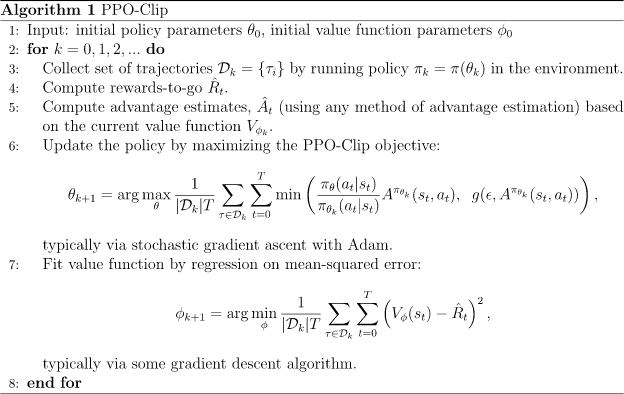 

where 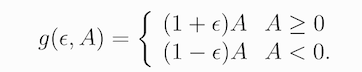

A commonly used technique is to add entropy regularization for policy gradient methods as shown in equation 2 of [this paper](https://arxiv.org/pdf/1611.01626.pdf), and there is some discussion of entropy regularization in this [reference tutorial](https://arxiv.org/pdf/1805.00909.pdf). You should compute the policy loss as defined above and also add in an entropy term for the updated policy (note that we've provided to you an entropy coefficient in `args.entropy_coef`).

In [23]:
def update_parameters_ppo(optimizer, acmodel, sb, args, target_params,critic_index = 1):
    def _compute_policy_loss_ppo(obs, old_logp, actions, advantages):
        policy_loss, approx_kl = 0, 0

        ### TODO: implement PPO policy loss computation (30 pts).  #######
        # approx kl 5
        # a few ways to approximate - 
        #  k1 = -logr
        #  k2 = logr ** 2 / 2
        #  k3 = (logr.exp() - 1) - logr
        #  or p * log(p/q)
        # entropy term 5 
        # ratio clamping/clipping 10
        # remaining correctness 10
        new_dist, _ = acmodel(obs)
        new_logp = new_dist.log_prob(actions)

        ratio = torch.exp(new_logp - old_logp)
        clip_adv = torch.clamp(ratio, 1-args.clip_ratio, 1+args.clip_ratio) * advantages

        entropy_loss = -args.entropy_coef * new_dist.entropy().mean()
        policy_loss = -(torch.min(ratio*advantages, clip_adv)).mean() 
        policy_loss += entropy_loss

        approx_kl = 0.5 * ((old_logp - new_logp).mean().item()) ** 2

        ##################################################################
        
        return policy_loss, approx_kl
    
    def _compute_value_loss(obs, returns, critic_index):
        ### TODO: implement PPO value loss computation (10 pts) ##########
        returns = returns.repeat(acmodel.num_critics,1).T
        _, values = acmodel(obs)
        value_loss = (values[:,critic_index] - returns[:,critic_index]).pow(2).mean()
        ##################################################################

        return value_loss


    dist, _ = acmodel(sb['obs'])            
    old_logp = dist.log_prob(sb['action']).detach()
    
    advantage = sb['advantage_gae'] if args.use_gae else sb['advantage']

    policy_loss, _ = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
    #value_loss = _compute_value_loss(sb['obs'], sb['discounted_reward'], critic_index = critic_index)

    for i in range(args.train_ac_iters):
        optimizer.zero_grad()
        loss_pi, approx_kl = _compute_policy_loss_ppo(sb['obs'], old_logp, sb['action'], advantage)
        if target_params == "actor": 
          loss = loss_pi
        else:
          loss_v = _compute_value_loss(sb['obs'], sb['discounted_reward'],critic_index = critic_index)
          loss = loss_v

        if approx_kl > 1.5 * args.target_kl:
            break
        
        loss.backward(retain_graph=True)
        optimizer.step()
    
    update_policy_loss = policy_loss.item()
    #update_value_loss = value_loss.item()

    logs = {
        "policy_loss": update_policy_loss,
        "value_loss": 69,
    }

    return logs

In [ ]:
# rewards = ["threshold", "exponential", "explore"]
rewards = [ "explore","threshold"]
c = [1,2,3,4]
thresh = [10,30,150,500,1000]
env_names = [
            #  'MiniGrid-Empty-5x5-v0',
            #  'MiniGrid-Empty-6x6-v0',
            #  'MiniGrid-Empty-8x8-v0',
            #  'MiniGrid-DoorKey-16x16-v0',

            #  'MiniGrid-ObstructedMaze-1Dl-v0',
            #  'MiniGrid-Unlock-v0'
            #  'MiniGrid-DoorKey-5x5-v0', ]
             'MiniGrid-DoorKey-6x6-v0']
            
env_map = {
    'MiniGrid-Empty-5x5-v0' : EmptyEnvSparse(size = 5),
    'MiniGrid-Empty-6x6-v0' : EmptyEnvSparse(size = 6),
    'MiniGrid-Empty-8x8-v0' : EmptyEnvSparse(size = 8),
    'MiniGrid-DoorKey-5x5-v0' : DoorKeyEnvSparse(size = 5),
    'MiniGrid-DoorKey-6x6-v0' : DoorKeyEnvSparse(size = 6),
    'MiniGrid-DoorKey-16x16-v0' : DoorKeyEnvSparse(size = 16),
    'MiniGrid-Dynamic-Obstacles-5x5-v0' : DynamicObstaclesEnv5x5(),
    # 'MiniGrid-ObstructedMaze-1Dl-v0' : ObstructedMaze_1Dlhb(),
    'FourRoom' : FourRoomsEnv(),
    'KeyCorridor' : KeyCorridor(),
    'MiniGrid-Unlock-v0' : Unlock()
}

num_seeds = 5
df_master = pd.DataFrame()
for i in range(num_seeds):
  for j, reward in enumerate(rewards):
    for env_name in env_names:
      if j == 0:
          args.num_critics = 1
          df_ppo = run_experiment(args, update_parameters_ppo)
          df_ppo['Algorithm'] = 'Baseline'
          df_ppo['Seed'] = i
          df_ppo['environment'] = env_name
          df_ppo['episode'] = np.arange(df_ppo.shape[0])
          df_master = pd.concat((df_master,df_ppo),ignore_index=True)
      if reward == "explore":
        for coef in c:
          args = Config(use_critic=True, use_gae=True)
          args.max_episodes = 5000
          args.env = env_map[env_name]
          args.env_name = env_name
          args.explore_c = coef

          args.reward = reward
          args.env_name = env_name 
          args.num_critics = 10

          df_ppo = run_experiment(args, update_parameters_ppo)
          df_ppo['Algorithm'] = reward
          df_ppo['Hyperparam'] = coef
          df_ppo['Seed'] = i
          df_ppo['environment'] = env_name
          df_ppo['episode'] = np.arange(df_ppo.shape[0])
          df_master = pd.concat((df_master,df_ppo),ignore_index=True)
      elif reward == "threshold":
        for th in thresh:
          args = Config(use_critic=True, use_gae=True)
          args.max_episodes = 5000
          args.env = env_map[env_name]
          args.env_name = env_name
          args.t = th

          args.reward = reward
          args.env_name = env_name 
          args.num_critics = 10


          df_ppo = run_experiment(args, update_parameters_ppo)
          df_ppo['Algorithm'] = reward
          df_ppo['Hyperparam'] = th
          df_ppo['Seed'] = i
          df_ppo['environment'] = env_name
          df_ppo['episode'] = np.arange(df_ppo.shape[0])
          df_master = pd.concat((df_master,df_ppo),ignore_index=True)
        

    with open('probability_doorkey6x6.pkl', 'wb') as f:
      pickle.dump(df_master, f)

  0%|          | 0/5000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

Solved!


  0%|          | 0/10000 [00:00<?, ?it/s]

In [27]:
# from pickle
infile = open('probability_doorkey5x5.pkl','rb')
df = pickle.load(infile)
infile.close()

In [75]:
baseline_df = df[df['Algorithm'] == 'Baseline']
new_df_master = df.groupby(['Algorithm','Seed','Hyperparam']).max('episode')
new_df_master

new_df_master = new_df_master.groupby(['Algorithm','Hyperparam']).mean('episode')
baseline_df = baseline_df.groupby('Seed').max('episode')
baseline_mean = baseline_df['episode'].mean()
print('baseline mean: {}'.format(baseline_mean))
print('----------------------------------')
new_df_master['episode']


baseline mean: 230.6
----------------------------------


Algorithm  Hyperparam
explore    1.0            184.0
           2.0            139.0
           3.0            264.2
           4.0            754.4
threshold  10.0           226.2
           30.0           245.0
           150.0          180.0
           500.0         1026.2
           1000.0         226.4
Name: episode, dtype: float64

In [79]:
b = df[df['Algorithm'] == 'Baseline'].assign(Algorithm = 'Baseline')
new_plot_df_master = pd.concat((b,df[df['Hyperparam'] == 2]),ignore_index=True)
new_plot_df_master = pd.concat((new_plot_df_master,df[df['Hyperparam'] == 150]),ignore_index=True)


[Text(0.5, 1.0, 'Comparison of Various Model-Free RL Algorithms on DoorKey')]

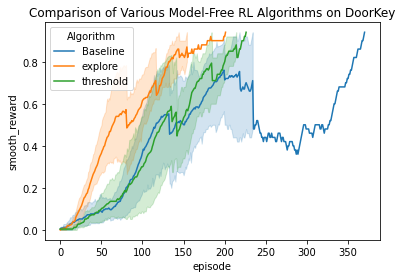

In [84]:
sns.lineplot(data=new_plot_df_master, x="episode", y="smooth_reward", hue="Algorithm",estimator="mean").set(
    title='Comparison of Various Model-Free RL Algorithms on DoorKey5x5')